## SciPy 2020

In [8]:
import podpac
from podpac.datalib.modis_pds import MODIS
from podpac.datalib.terraintiles import TerrainTiles
from podpac.algorithm import Arithmetic

from podpac import settings

In [10]:
# this is required for Arithmetic node below
settings.set_unsafe_eval(True)

In [11]:
# default coordinates
lat = podpac.clinspace(40, 41, 100)
lon = podpac.clinspace(-79, -78, 100)
time = ['2020-03-05', '2020-03-06']
coords = podpac.Coordinates([lat, lon, time], dims=['lat', 'lon', 'time'])

In [12]:
# ipyleaflet (https://github.com/jupyter-widgets/ipyleaflet)
import ipyleaflet

# show coordinates on map
lat_center = coords["lat"].bounds[0] + (coords["lat"].bounds[1]-coords["lat"].bounds[0])/2
lon_center = coords["lon"].bounds[0] + (coords["lon"].bounds[1]-coords["lon"].bounds[0])/2
m = ipyleaflet.Map(zoom=7, center=(lat_center, lon_center))
region = ipyleaflet.Rectangle(bounds=((coords["lat"].bounds[0], coords["lon"].bounds[0]), (coords["lat"].bounds[1], coords["lon"].bounds[1])))
m.add_layer(region)
m

Map(center=[40.5, -78.5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [13]:
# terrain data
terrain = TerrainTiles(zoom=6)

# Spectral data: https://modis.gsfc.nasa.gov/about/specifications.php
# band 1: 620-670 nm (red)
modis_red = MODIS(product="MCD43A4.006", data_key="B01")

# band 2: 841-876 nm (NIR)
modis_nir = MODIS(product="MCD43A4.006", data_key="B02")

# ndvi
ndvi = Arithmetic(A=modis_red, B=modis_nir, eqn="(B - A)/(A + B)")

In [14]:
# look at NDVI for coordinates
o_ndvi = ndvi.eval(coords)
o_ndvi.plot()

INFO:podpac.datalib.modis_pds:Looking up available tiles...
INFO:podpac.datalib.modis_pds:Looking up available dates (product=MCD43A4.006, h=11, v=04)...
INFO:podpac.datalib.modis_pds:Looking up source filename (product=MCD43A4.006, h=11, v=04, date=2020065, data_key=B01)...
INFO:podpac.core.data.file_source:Loading AWS resource: s3://modis-pds/MCD43A4.006/11/04/2020065/MCD43A4.A2020065.h11v04.006.2020076221940_B01.TIF
INFO:podpac.datalib.modis_pds:Looking up source filename (product=MCD43A4.006, h=11, v=04, date=2020066, data_key=B01)...
INFO:podpac.core.data.file_source:Loading AWS resource: s3://modis-pds/MCD43A4.006/11/04/2020066/MCD43A4.A2020066.h11v04.006.2020077194341_B01.TIF
INFO:podpac.datalib.modis_pds:Looking up available dates (product=MCD43A4.006, h=12, v=04)...
INFO:podpac.datalib.modis_pds:Looking up source filename (product=MCD43A4.006, h=12, v=04, date=2020065, data_key=B01)...
INFO:podpac.core.data.file_source:Loading AWS resource: s3://modis-pds/MCD43A4.006/12/04/202

<xarray.UnitsDataArray (lat: 100, lon: 100, time: 2)>
array([[[       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       [[0.44244898, 0.44774194],
        [0.39382088, 0.39453125],
        [0.35016939, 0.34952352],
        ...,
        [0.50304735, 0.50659991],
        [0.43394911, 0.44050104],
        [0.42551813, 0.42609299]],

       [[0.40576497, 0.40558292],
        [0.45439538, 0.45315315],
        [0.39337176, 0.39495798],
        ...,
        [0.55245385, 0.55187835],
        [0.58499096, 0.57809695],
        [0.59536082, 0.59452524]],

       ...,

       [[0.47130435, 0.47211243],
        [0.52915194, 0.52733686],
        [0.50668194, 0.5       ],
        ...,
        [0.54876937, 0.54835766],
        [0.45669291, 0.46806649],
        [0.46978386, 0.47714159]],

       [[0.43283582, 0.4360424 ],
        [0.43293493, 0.

INFO:podpac.core.data.file_source:Loading AWS resource: s3://elevation-tiles-prod/geotiff/6/17/23.tif
INFO:podpac.core.data.file_source:Loading AWS resource: s3://elevation-tiles-prod/geotiff/6/18/23.tif
INFO:podpac.core.data.file_source:Loading AWS resource: s3://elevation-tiles-prod/geotiff/6/17/24.tif
INFO:podpac.core.data.file_source:Loading AWS resource: s3://elevation-tiles-prod/geotiff/6/18/24.tif


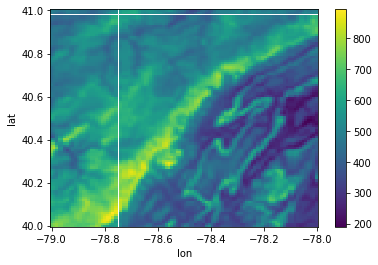

In [15]:
# look at the terrain
o_terrain = terrain.eval(coords.drop("time"))
o_terrain.plot()

In [17]:
# Write algorithm that sees if ndvi is different at lower elevation
import traitlets as tl     # the traitlets library is used to enforce input types

# Create a new class, inheriting from Algorithm node
class GreenElevation(podpac.algorithm.Algorithm):
    
    # Define the inputs as PODPAC nodes
    elevation = tl.Instance(podpac.Node)
    ndvi = tl.Instance(podpac.Node)
    
    # Define the algorithm
    # Note, "inputs" is a dictionary with keys corresponding to any class attributes 
    # of type "Node", in this case 'elevation', and 'soil_moisture'
    def algorithm(self, inputs):
        
        # See if wetter soil_moisture is found at lower elevation
        median_sm = inputs['ndvi'].median()
        median_elev = inputs['elevation'].median()
        
        return (inputs['ndvi'] > median_sm) & (inputs['elevation'] <= median_elev)

In [19]:
coords

Coordinates (EPSG:4326)
	lat: UniformCoordinates1d(lat): Bounds[40.0, 41.0], N[100]
	lon: UniformCoordinates1d(lon): Bounds[-79.0, -78.0], N[100]
	time: ArrayCoordinates1d(time): Bounds[2020-03-05, 2020-03-06], N[2]

In [20]:
# Make an instance of the algorithm
green_elevation = GreenElevation(elevation=terrain, ndvi=ndvi)

# Evaluate node
o_green_elevation = green_elevation.eval(coords)
o.green_elevation.plot()

ValueError: Cannot evaluate these coordinates, missing dim 'time'